# Numerical Analysis of Trotter Error
Aims:
- verify that single-step Trotter error of my simulation follws expected scaling law
- evaluate prefactors of the fit function to investigate for further (unaccounted for) dependences 

References:
  1. https://journals.aps.org/prx/pdf/10.1103/PhysRevX.11.011020 _Theory of Trotter Error with Commutator Scaling_

# Requirements

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from iminuit import Minuit
from iminuit.cost import LeastSquares  
from functools import partial


mu = 1

## Theoretical requirements

### Theorem 1: Trotter error with commutator scaling  
Let $H = \sum_{\gamma=1}^{\Gamma} H_\gamma$ be an operator consisting of $\Gamma$ summands, and let $t \ge 0$. Let $S(t) = \prod_{\upsilon=1}^{\Upsilon} \prod_{\gamma=1}^{\Gamma}\exp\left( t\, a_{\upsilon,\gamma}\, H_{\pi_\upsilon(\gamma)} \right)$ be a $p$-th order product formula. Define 
$$
\tilde{\alpha}_{\text{comm}} = \sum_{\gamma_1,\gamma_2,\ldots,\gamma_{p+1}=1}^{\Gamma} \left\| \big[ H_{\gamma_{p+1}}, \ldots, [ H_{\gamma_2}, H_{\gamma_1} ] \ldots \big] \right\|.
\tag{1}
$$

Then the **additive Trotter error** and the **multiplicative Trotter error**, defined respectively by
$$
S(t) = e^{tH} + A(t),\quad S(t) = e^{tH}\,(I + M(t))
$$
can be asymptotically bounded as
$$
\|A(t)\|,\; \|M(t)\|
= \mathcal{O}\!\left(
\tilde{\alpha}_{\mathrm{comm}} \, t^{p+1}
\, e^{\,4 t \Upsilon \sum_{\gamma=1}^{\Gamma} \|H_\gamma\|}
\right).
$$

Furthermore, if the operators $H_\gamma$ are anti-Hermitian,
$$
\|A(t)\|,\; \|M(t)\|
= \mathcal{O}\!\left(
\tilde{\alpha}_{\mathrm{comm}} \, t^{p+1}
\right).
$$

### Theorem 2: Tight error bound for the first-order Lie-Trotter formula
Let $ H = \sum_{\gamma=1}^{\Gamma} H_\gamma $
be a Hamiltonian consisting of $\Gamma$ summands, and let $t \ge 0$.
Let $S_1(t) = \prod_{\gamma=1}^{\Gamma} e^{-it H_\gamma}$ be the first-order Lie–Trotter formula.
Then the additive Trotter error can be bounded as
$$
\bigl\| S_1(t) - e^{-itH} \bigr\|
\le
\frac{t^2}{2}
\sum_{\gamma_1=1}^{\Gamma}
\sum_{\gamma_2=\gamma_1+1}^{\Gamma}
\bigl\| [ H_{\gamma_2}, H_{\gamma_1} ] \bigr\|.
$$

### Theorem 3: Tight error bound for the second-order Lie-Trotter formula
Let $H = \sum_{\gamma=1}^{\Gamma} H_\gamma$ be a Hamiltonian consisting of $\Gamma$ summands, and let $t \ge 0$. Let $S_2(t)= \prod_{\gamma=\Gamma}^{1} e^{-i (t/2) H_\gamma}  \prod_{\gamma=1}^{\Gamma} e^{-i (t/2) H_\gamma}$ be the second-order Suzuki formula. Then, the additive Trotter error can be bounded as
$$
\begin{aligned}
\bigl\| S_2(t) - e^{-itH} \bigr\|
\le {} &
\frac{t^3}{12}
\sum_{\gamma_1=1}^{\Gamma}
\left\|
\sum_{\gamma_3=\gamma_1+1}^{\Gamma}
\Bigl[
H_{\gamma_3},
\sum_{\gamma_2=\gamma_1+1}^{\Gamma}
[ H_{\gamma_2}, H_{\gamma_1} ]
\Bigr]
\right\| \\
& {} +
\frac{t^3}{24}
\sum_{\gamma_1=1}^{\Gamma}
\left\|
\Bigl[
H_{\gamma_1},
\bigl[
H_{\gamma_1},
\sum_{\gamma_2=\gamma_1+1}^{\Gamma} H_{\gamma_2}
\bigr]
\Bigr]
\right\|.
\end{aligned}
$$



# First Order Analysis
Fit the scaling laws of the various dependences of the first order additive error and tight error bound to fit functions that depend on the parameters of the system.
## Additive Trotter Error
Use Theorem 1 under the following set of hypothesis: 
- $H = H^N = H_{XY}^N + H_{XZ}^N + H_{YZ}^N \equiv H_1 + H_2 + H_3$ 
- $\Gamma = 3$ (implied by the Hamiltonian decomposition)
- $S(t) = S_1(t) = \prod_{\gamma=1}^{\Gamma} e^{-it H_\gamma}$ $\implies$ $p=1$ order product formula. 
$\implies \left\|\mathcal{A}(t, N, \left\{g_{ij}\right\}_{i<j})\right\| = \mathcal{O}(\tilde{\alpha}_\text{comm}(N,\left\{g_{ij}\right\}_{i<j})t^2)$

Define $\mathcal{G} \coloneqq \left\{g_{ij}\right\}_{i<j}$.

Under these assumptions, $\tilde{\alpha}_\text{comm}(N,\left\{g_{ij}\right\}_{i<j})$ takes the following expression:

$$
\begin{split}
\tilde{\alpha}_\text{comm} 
&= \sum_{\gamma_1,\gamma_2=1}^3 \left\|\left[H_{\gamma_2},H_{\gamma_1}\right]\right\| = \\
&= \sum_{\gamma_2 = 1}^3 \left(\left\|\left[H_{\gamma_2},H_1\right]\right\|+\left\|\left[H_{\gamma_2},H_2\right]\right\|+\left\|\left[H_{\gamma_2},H_3\right]\right\|\right)\\
&= \left(\|[H_1,H_2]\|+\|[H_1,H_3]\|\right)
  +\left(\|[H_2,H_1]\|+\|[H_2,H_3]\|\right)
  +\left(\|[H_3,H_1]\|+\|[H_3,H_2]\|\right) \\
&= 2(\|[H_1,H_2]\|+\|[H_1,H_3]\|+\|[H_2,H_3]\|) \\
\end{split}
$$

$$
\tilde{\alpha}_\text{comm} = 2(\|[H_1,H_2]\|+\|[H_1,H_3]\|+\|[H_2,H_3]\|)
$$

Work it out:
$$
\begin{split}
\tilde{\alpha}_\text{comm} &= 2(\|[H_1,H_2]\|+\|[H_1,H_3]\|+\|[H_2,H_3]\|) \\
&= \frac{1}{2}\left(\sum_{p<q}^N\sum_{m<n}^Ng_{pq}g_{mn}\|[X_pX_q + Y_qY_q,X_pX_q + Z_qZ_q]\|
                   +\sum_{p<q}^N\sum_{m<n}^Ng_{pq}g_{mn}\|[X_pX_q + Y_qY_q,Y_pY_q + Z_qZ_q]\|
                   +\sum_{p<q}^N\sum_{m<n}^Ng_{pq}g_{mn}\|[X_pX_q + Z_qZ_q,Y_pY_q + Z_qZ_q]\|\right) \\
\end{split}
$$
For a dense gas of neutrinos forming a peaked beam:
$$
g_{ij} = \frac{\mu}{N}\left(1-\cos\theta_{ij}\right) = \frac{\mu}{N}\left(1-\cos\left(\arccos\left(\upsilon\right)\frac{|i-j|}{N-1}\right)\right) 
$$
Define $\Theta = \max_{i,j}\left(1-\cos\theta_{ij}\right)$. Note that $\Theta = \Theta(\upsilon)$, that is, depends only on the peakness of the beam, because $\max_{i,j}\left(1-\cos\theta_{ij}\right)$ is obtained for $|i-j| = N-1 \implies \Theta = 1-\upsilon$ which is independent of $N$.

Hence:
$$
\begin{split}
\tilde{\alpha}_\text{comm} 
&= 2(\|[H_1,H_2]\|+\|[H_1,H_3]\|+\|[H_2,H_3]\|) \\
&= \frac{1}{2}\left(\sum_{p<q}^N\sum_{m<n}^Ng_{pq}g_{mn}\|[X_pX_q + Y_qY_q,X_pX_q + Z_qZ_q]\|
                   +\sum_{p<q}^N\sum_{m<n}^Ng_{pq}g_{mn}\|[X_pX_q + Y_qY_q,Y_pY_q + Z_qZ_q]\|
                   +\sum_{p<q}^N\sum_{m<n}^Ng_{pq}g_{mn}\|[X_pX_q + Z_qZ_q,Y_pY_q + Z_qZ_q]\|\right) \\
&\leq \frac{\mu^2\Theta^2}{2N^2}\left(
     \sum_{p<q}^N\sum_{m<n}^N\|[X_pX_q + Y_qY_q,X_pX_q + Z_qZ_q]\|
    +\sum_{p<q}^N\sum_{m<n}^N\|[X_pX_q + Y_qY_q,Y_pY_q + Z_qZ_q]\|
    +\sum_{p<q}^N\sum_{m<n}^N\|[X_pX_q + Z_qZ_q,Y_pY_q + Z_qZ_q]\|
    \right) \\
& = \frac{\mu^2\Theta^2}{2N^2}[\text{function of }N] \\
\end{split}
$$
A counting argument implies that $[\text{function of }N]\sim N^3$.

**Note**: how much are we overestimating the contribution of a generic term when the coupling is approximating with $\Theta$?
Consider the difference between a generic term of the above sums and the upper bound. Most stuff factorizes:
$$
\begin{split}
\text{error in a single term} 
&= \left|\Theta^2-(1-\cos\theta_{pq})(1-\cos\theta_{mn})\right|\\
&= \left|\Theta^2-\left[1-\cos\left(\arccos(\upsilon)\frac{|p-q|}{N-1}\right)\right]\left[1-\cos\left(\arccos(\upsilon)\frac{|m-n|}{N-1}\right)\right]\right| \\
&= \left[\text{see notes}\right] \\
&\implies \text{error in a single term} = \left|(1-\upsilon)^2+\mathcal{O}\left(\frac{\arccos(\upsilon)^4}{(N-1)^4}\right)\right|\rightarrow 0 \quad\text{for}\quad\upsilon\rightarrow1,\quad N\gg1 \\
\end{split}
$$
The error committed when majoring the single term goes to zero for highly peaked beam ($\upsilon\rightarrow 1$) and large number of neutrinos ($N\rightarrow\infty$). This is the case for the system in analysis, so the majoring is justified.

The quantity $\tilde{\alpha}_\text{comm}\left(N,\left\{g_{ij}\right\}_{i<j}\right)$ is bounded by $\mu^2\Theta^2N^3/2N^2 = \mu^2\left(1-\upsilon\right)^2N^3/2N^2$; consequently, the first order additive Trotter error is bounded by:
$$ 
\left\|\mathcal{A}(t, N, \left\{g_{ij}\right\}_{i<j})\right\| \leq \mathcal{O}(\mu^2\Theta^2Nt^2) = \mathcal{O}(\mu^2(1-\upsilon)^2Nt^2)
$$

## Fitting the first order additive Trotter error
Define $\vec{x}_k = \left(t_k,N_k,\mathcal{G}\left(N_k\right)\right)$. Consider the following set of data points: $\mathcal{D}=\left\{\left(\vec{x}_k,a_1(N_k,\mathcal{G}(N_k))t_k^2\right)\right\}$. Here, we define:
$$
a_1(\vec{x}_k) = \frac{1}{2}\left(\sum_{p<q}^N\sum_{m<n}^Ng_{pq}g_{mn}\|[X_pX_q + Y_qY_q,X_pX_q + Z_qZ_q]\|
                   +\sum_{p<q}^N\sum_{m<n}^Ng_{pq}g_{mn}\|[X_pX_q + Y_qY_q,Y_pY_q + Z_qZ_q]\|
                   +\sum_{p<q}^N\sum_{m<n}^Ng_{pq}g_{mn}\|[X_pX_q + Z_qZ_q,Y_pY_q + Z_qZ_q]\|\right)
$$
This quantity is computed numerically.

The data set is constructed by letting $t_k$ and $N_k$ vary over some discrete set of values; the values of the couplings are fixed by the value $N_k$ and the peakness $\upsilon$ of the beam:
$$
\mathcal{G}(N_k) = \left\{\frac{\mu}{N_k}\left(1-\cos\left(\upsilon\frac{|i-j|}{N_k-1}\right)\right), i,j = 1,\dots,N, i<j\right\}
$$
Moreover, as anticipated, $\Theta(\upsilon) = 1-\upsilon$ is independent of $N_k$. This is a key feature of the setup because it can be exploited to analyze the $N$ dependance of the Trotter error for system with the same peakness $\upsilon$.
The dependence on $\mu$ is taken care of by noting that $t$ and $\mu$ enter in $\tilde{\alpha}_\text{comm}$ only as powers $(\mu t)^k$, hence we simply choose $t_{k} = 10^sk/\mu, k=0,\dots,N_t$, and $s\in\mathbb{Z}$ is a scale factor to be fixed in the actual simulation.

### Fit of $t$ dependance
The dependance of the norm of the additive Trotter error on $t$ is known from theory to be quadratic. We test the numerical routines against this benchmark by fitting the time dependance of the Trotter error for various system parameters. 

To fit the time dependance, fix $N\coloneqq\overline{N}$, $\mathcal{G}(\overline{N})\coloneqq\overline{\mathcal{G}}$ and let $T=\left\{t_k=10^sk/\mu, k=0,\dots,N_t, s=\overline{s}\right\}$ (for some fixed value $\overline{s}$). The data set for a single fit of the time dependance is given by:
$$
\mathcal{D}_t^1 = \left\{\left((t_k,\overline{N},\overline{\mathcal{G}}),a_1(\overline{N},\overline{\mathcal{G}})\cdot t_k^2\right), t_k\in T\right\}
$$
This dataset is fitted to the following function:
$$
\mathcal{F}_t^1(t, \overline{N},\overline{\mathcal{G}}; C_1, \beta_1) = C_1\frac{\mu^2\overline{\Theta}^2}{2}\overline{N} t^{\beta_1}
$$

In [59]:
peakness_vls = np.arange(-100, 100) * 1e-2
N_vls = np.arange(3, 11)
dt_list = np.arange(1, 10) / mu

beta_vals = np.zeros((len(N_vls), len(peakness_vls)))
C_vals    = np.zeros((len(N_vls), len(peakness_vls)))

terms_dict = {
    N: (
        globals()[f"terms_XY{N}XZ{N}"],
        globals()[f"terms_XY{N}YZ{N}"],
        globals()[f"terms_XZ{N}YZ{N}"],
    )
    for N in N_vls
}

# Main loop
for iN, N in enumerate(N_vls):
    terms = terms_dict[N]
    # print(f"N = {N}")

    for ip, peak in enumerate(peakness_vls):
        # print(f"peakness = {peak}")

        couplings, angles = fp_couplings(N, peak, mu)

        err_vls = []
        for dt in dt_list: err_vls.append(fixed_t_commsum_T1(terms, couplings, dt))

        def model(x, C, beta):
            return 0.5 * C * (mu**2) * (Theta(angles)**2) * N * (x**beta)

        # ---------- fit ----------
        ls_obj = LeastSquares(dt_list, np.array(err_vls), 0.001, model)
        m_obj = Minuit(ls_obj, C=1, beta=1)
        m_obj.migrad()
        m_obj.hesse()

        beta_vals[iN, ip] = m_obj.values["beta"]
        C_vals[iN, ip]    = m_obj.values["C"]

C:\Users\edori\AppData\Local\Temp\ipykernel_39512\281463999.py:31: RuntimeWarning: overflow encountered in power
  return 0.5 * C * (mu**2) * (Theta(angles)**2) * N * (x**beta)
c:\Users\edori\AppData\Local\Programs\Python\Python313\Lib\site-packages\iminuit\cost.py:172: RuntimeWarning: overflow encountered in multiply
  return z * z


KeyboardInterrupt: 

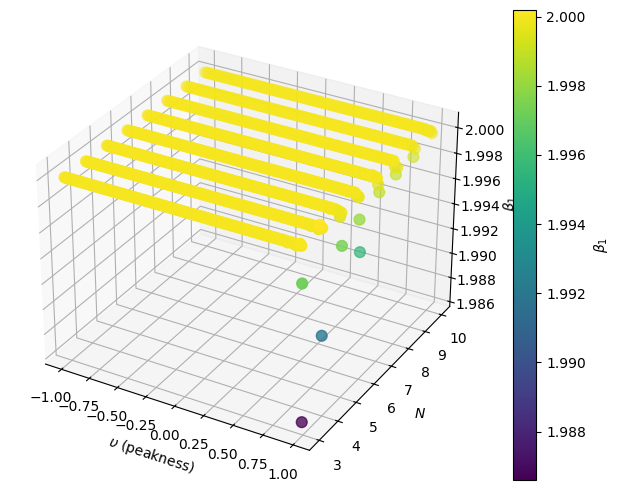

In [55]:
P, Ngrid = np.meshgrid(peakness_vls, N_vls)

fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(111, projection="3d")

sc = ax.scatter(
    P.ravel(),
    Ngrid.ravel(),
    beta_vals.ravel(),
    c=beta_vals.ravel(),
    cmap="viridis",
    s=60
)

ax.set_xlabel(r"$\upsilon$ (peakness)")
ax.set_ylabel(r"$N$")
ax.set_zlabel(r"$\beta_1$")

fig.colorbar(sc, ax=ax, label=r"$\beta_1$")

plt.tight_layout()
plt.show()

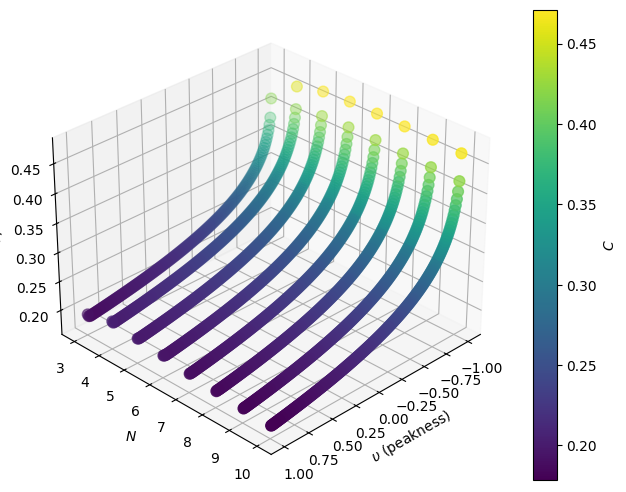

In [ ]:
P, Ngrid = np.meshgrid(peakness_vls, N_vls)

fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(111, projection="3d")

sc = ax.scatter(
    P.ravel(),
    Ngrid.ravel(),
    C_vals.ravel(),
    c=C_vals.ravel(),
    cmap="viridis",
    s=60
)

ax.set_xlabel(r"$\upsilon$ (peakness)")
ax.set_ylabel(r"$N$")
ax.set_zlabel(r"$C_1$")

# Rotate by 90 degrees
ax.view_init(elev=30, azim=45)

fig.colorbar(sc, ax=ax, label=r"$C_1$")

plt.tight_layout()
plt.show()

### Fit of N dependance
The dependance of the norm of the additive Trotter error on $N$ is known from a counting argument to be linear. We use the numerical routines to fit the $N$ dependance of the Trotter error for various system and simulation parameters. 

To fit the $N$ dependance, fix $t\coloneqq\overline{t}$, $\mathcal{G}(\overline{N})\coloneqq\overline{\mathcal{G}}$ and let $\mathcal{N}=\left\{N_k=k, k=3,\dots,N_N, s=\overline{s}\right\}$ (for some fixed value $\overline{s}$). The data set for a single fit of the $N$ dependance is given by:
$$
\mathcal{D}_N^1 = \left\{\left((\overline{t},N_k,\overline{\mathcal{G}}),a_1(N_k,\overline{\mathcal{G}})\cdot \overline{t}^2\right), N_k\in \mathcal{N}\right\}
$$
This dataset is fitted to the following function:
$$
\mathcal{F}_N^1(\overline{t}, N_k,\overline{\mathcal{G}}; K_1, \gamma_1) = K_1\frac{\mu^2\overline{\Theta}^2}{2}\overline{N} t^{\gamma_1}
$$


C:\Users\edori\AppData\Local\Temp\ipykernel_39512\2419447367.py:2: RuntimeWarning: overflow encountered in power
  return mu**2 * Kp * x**(gammap-2) / 8


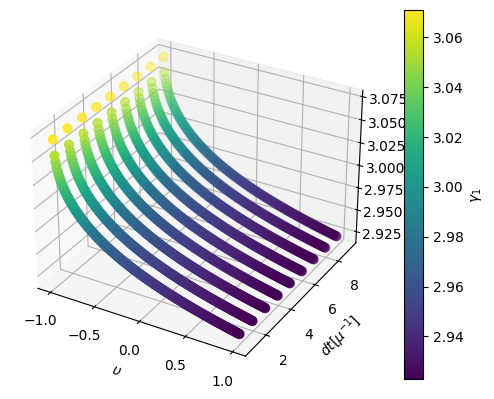

In [62]:
def model_timenorm_m2(x, gammap, Kp):
    return mu**2 * Kp * x**(gammap-2) / 8

peakness_vls = np.arange(-100,100) * 1e-2
slopes_altfit = []
dt_list = np.arange(1,10) / mu

xs_altfit = []
ys_altfit = []
zs_altfit = []
Ks = []

for peak in peakness_vls:
    for dt in dt_list:
        err_vls_dt = []

        couplings3, angles3 = fp_couplings(3, peak, mu)
        couplings4, angles4 = fp_couplings(4, peak, mu)
        couplings5, angles5 = fp_couplings(5, peak, mu)
        couplings6, angles6 = fp_couplings(6, peak, mu)
        couplings7, angles7 = fp_couplings(7, peak, mu)
        couplings8, angles8 = fp_couplings(8, peak, mu)

        err_vls_dt.append(fixed_t_commsum_T1([terms_XY3XZ3, terms_XY3YZ3, terms_XZ3YZ3], couplings3, dt)/dt**2/Theta(angles3)**2)
        err_vls_dt.append(fixed_t_commsum_T1([terms_XY4XZ4, terms_XY4YZ4, terms_XZ4YZ4], couplings4, dt)/dt**2/Theta(angles4)**2)
        err_vls_dt.append(fixed_t_commsum_T1([terms_XY5XZ5, terms_XY5YZ5, terms_XZ5YZ5], couplings5, dt)/dt**2/Theta(angles5)**2)
        err_vls_dt.append(fixed_t_commsum_T1([terms_XY6XZ6, terms_XY6YZ6, terms_XZ6YZ6], couplings6, dt)/dt**2/Theta(angles6)**2)
        err_vls_dt.append(fixed_t_commsum_T1([terms_XY7XZ7, terms_XY7YZ7, terms_XZ7YZ7], couplings7, dt)/dt**2/Theta(angles7)**2)
        err_vls_dt.append(fixed_t_commsum_T1([terms_XY8XZ8, terms_XY8YZ8, terms_XZ8YZ8], couplings8, dt)/dt**2/Theta(angles8)**2)

        ls_obj = LeastSquares(values_N, err_vls_dt, 0.001, model_timenorm_m2)
        m_obj = Minuit(ls_obj, gammap=1, Kp=1)
        m_obj.migrad()
        m_obj.hesse()

        slopes_altfit.append(m_obj.values[0])
        xs_altfit.append(peak)
        ys_altfit.append(dt*mu)
        zs_altfit.append(m_obj.values[0])   
        Ks.append(m_obj.values[1])      


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(xs_altfit, ys_altfit, zs_altfit, c=zs_altfit, cmap="viridis", s=40)

ax.set_xlabel(r"$\upsilon$")
ax.set_ylabel(r"$dt[\mu^{-1}]$")
ax.set_zlabel(r"$\gamma$")
fig.colorbar(scatter, ax=ax, label=r"$\gamma_1$")

plt.show()

# Core functions

In [54]:
def gen_Heisenberg_terms(N):
        XY = [] 
        XZ = []   
        YZ = [] 

        for i in range(N):
            for j in range(i+1, N):
                gate_id = f"g{i+1}{j+1}" 

                xx_term = ["X" if k == i or k == j else "I" for k in range(N)]
                yy_term = ["Y" if k == i or k == j else "I" for k in range(N)]
                zz_term = ["Z" if k == i or k == j else "I" for k in range(N)]

                XY.append((0.5, gate_id, "".join(xx_term)))
                XY.append((0.5, gate_id, "".join(yy_term)))

                XZ.append((0.5, gate_id, "".join(xx_term)))
                XZ.append((0.5, gate_id, "".join(zz_term)))

                YZ.append((0.5, gate_id, "".join(yy_term)))
                YZ.append((0.5, gate_id, "".join(zz_term)))

        return XY, XZ, YZ

# -------------------------------------------------------------------------------------------------------------------------------
# ###############################################################################################################################
# -------------------------------------------------------------------------------------------------------------------------------


pauli_mult_table = {
    ('I', 'I'): (1, 'I'),
    ('I', 'X'): (1, 'X'),
    ('I', 'Y'): (1, 'Y'),
    ('I', 'Z'): (1, 'Z'),
    ('X', 'I'): (1, 'X'),
    ('Y', 'I'): (1, 'Y'),
    ('Z', 'I'): (1, 'Z'),
    ('X', 'X'): (1, 'I'),
    ('Y', 'Y'): (1, 'I'),
    ('Z', 'Z'): (1, 'I'),
    ('Y', 'Z'): (+1j, 'X'),
    ('X', 'Y'): (+1j, 'Z'),
    ('Z', 'X'): (+1j, 'Y'),
    ('Y', 'X'): (-1j, 'Z'),
    ('Z', 'Y'): (-1j, 'X'),
    ('X', 'Z'): (-1j, 'Y'),
    ('0', 'I'): (0, '0'),
    ('0', 'X'): (0, '0'),
    ('0', 'Y'): (0, '0'),
    ('X', '0'): (0, '0'),
    ('I', '0'): (0, '0'),
    ('X', '0'): (0, '0'),
    ('Y', '0'): (0, '0'),
    ('Z', '0'): (0, '0')
}

# -------------------------------------------------------------------------------------------------------------------------------
# ###############################################################################################################################
# -------------------------------------------------------------------------------------------------------------------------------

def comm_pstr(pstr1, pstr2):
    """
    `comm_pstr(self, pstr1, pstr2)`
    pstr1, pstr2 (tuple): (numeric coefficient, couplings, individual Pauli string)

    comm_pstr function computes the commutator [pstr1, pstr2], keeping track of resulting numeric coefficient and coupling combination.
    return: (numeric coefficient, couplings, individual Pauli string) (tuple)
    """
    ps1 = pstr1[2] # e.g. "IXX"
    ps2 = pstr2[2] # e.g. "YIY"

    coeff = pstr1[0] * pstr2[0]
    psfinal = ""
    acomm_cnt = 0

    for i in range(len(ps1)):
        p1 = ps1[i]
        p2 = ps2[i]

        if p1 != p2 and p1 != 'I' and p2 != 'I': acomm_cnt += 1

        pair = pauli_mult_table[(p1, p2)]
        coeff = coeff * pair[0]
        psfinal += pair[1]

    if acomm_cnt % 2 == 0 or '0' in psfinal:
        return (0, "", '0'*len(ps1))
    
    return (2*coeff, f"({pstr1[1]})({pstr2[1]})", psfinal) # factor of 2 is introduced here

# -------------------------------------------------------------------------------------------------------------------------------
# ###############################################################################################################################
# -------------------------------------------------------------------------------------------------------------------------------

def comm_lincombo(psum1, psum2):
    """
    `comm_lincombo(self, psum1, psum2)`
    psum1, psum2 (list of tuples): [(numeric coefficient 1, couplings 1, individual Pauli string 1), ...]

    comm_lincombo computes the commutator of two sums of Pauli strings, keeping track of numerical coefficients and coupling powers.
    return: [(resulting numeric coefficient 1, resulting couplings 1, resulting individual Pauli string 1), ...] (list of tuples)
    """
    list_comm = []

    for elem1 in psum1:
        for elem2 in psum2:
            res = comm_pstr(elem1, elem2)
            if '0' not in res[2]: list_comm.append((res[0], res[1], res[2]))

    return list_comm

# -------------------------------------------------------------------------------------------------------------------------------
# ###############################################################################################################################
# -------------------------------------------------------------------------------------------------------------------------------

def group_by_pauli_string(comm, N):
    """
    `group_by_pauli_string(comm, N)`
    comm (list of tuples): [(numeric coefficient, couplings, Pauli string), ...]
    N (int)              : number of qubits

    group_by_pauli_string groups terms with the same Pauli string, and within those terms sums
    contributions with the same coupling coefficient

    return: dict {Pauli string: [[coefficient, coupling], ...], ...} 
    """

    def is_coeff_equal(str1, str2):
        pair1 = str1.split(")(")        
        pair2 = str2.split(")(")
        pair1 = [p.strip('(').strip(')').strip('g') for p in pair1]
        pair2 = [p.strip('(').strip(')').strip('g') for p in pair2]

        return sorted(pair1) == sorted(pair2)
        
    list_terms = {}
    for term in comm:
        if term[2] != "0"*N:
            if term[2] not in list_terms:
                list_terms[term[2]] = [[term[0], term[1]]]
            else:
                cnt_not = 0 
                for i, elem in enumerate(list_terms[term[2]]):
                    if is_coeff_equal(term[1], elem[1]):
                        list_terms[term[2]][i][0] += elem[0] # refactor coefficient
                    else:
                        cnt_not +=1 
                if cnt_not == len(list_terms[term[2]]): list_terms[term[2]].append([term[0], term[1]]) # TODO can it be changed to ([term[0], term[1])?

    return list_terms

# -------------------------------------------------------------------------------------------------------------------------------
# ###############################################################################################################################
# -------------------------------------------------------------------------------------------------------------------------------

values_N = np.arange(3,9)

XY3,  XZ3 , YZ3  = gen_Heisenberg_terms(3)
XY4,  XZ4 , YZ4  = gen_Heisenberg_terms(4)
XY5,  XZ5 , YZ5  = gen_Heisenberg_terms(5)
XY6,  XZ6 , YZ6  = gen_Heisenberg_terms(6)
XY7,  XZ7 , YZ7  = gen_Heisenberg_terms(7)
XY8,  XZ8 , YZ8  = gen_Heisenberg_terms(8)
XY9,  XZ9 , YZ9  = gen_Heisenberg_terms(9)
XY10, XZ10, YZ10 = gen_Heisenberg_terms(10)


XY3XZ3 = comm_lincombo(XY3, XZ3)
XY3YZ3 = comm_lincombo(XY3, YZ3)
XZ3YZ3 = comm_lincombo(XZ3, YZ3)

XY4XZ4 = comm_lincombo(XY4, XZ4)
XY4YZ4 = comm_lincombo(XY4, YZ4)
XZ4YZ4 = comm_lincombo(XZ4, YZ4)

XY5XZ5 = comm_lincombo(XY5, XZ5)
XY5YZ5 = comm_lincombo(XY5, YZ5)
XZ5YZ5 = comm_lincombo(XZ5, YZ5)

XY6XZ6 = comm_lincombo(XY6, XZ6)
XY6YZ6 = comm_lincombo(XY6, YZ6)
XZ6YZ6 = comm_lincombo(XZ6, YZ6)

XY7XZ7 = comm_lincombo(XY7, XZ7)
XY7YZ7 = comm_lincombo(XY7, YZ7)
XZ7YZ7 = comm_lincombo(XZ7, YZ7)

XY8XZ8 = comm_lincombo(XY8, XZ8)
XY8YZ8 = comm_lincombo(XY8, YZ8)
XZ8YZ8 = comm_lincombo(XZ8, YZ8)

XY9XZ9 = comm_lincombo(XY9, XZ9)
XY9YZ9 = comm_lincombo(XY9, YZ9)
XZ9YZ9 = comm_lincombo(XZ9, YZ9)

XY10XZ10 = comm_lincombo(XY10, XZ10)
XY10YZ10 = comm_lincombo(XY10, YZ10)
XZ10YZ10 = comm_lincombo(XZ10, YZ10)


terms_XY3XZ3 = group_by_pauli_string(XY3XZ3, N=3)
terms_XY3YZ3 = group_by_pauli_string(XY3YZ3, N=3)
terms_XZ3YZ3 = group_by_pauli_string(XZ3YZ3, N=3)

terms_XY4XZ4 = group_by_pauli_string(XY4XZ4, N=4)
terms_XY4YZ4 = group_by_pauli_string(XY4YZ4, N=4)
terms_XZ4YZ4 = group_by_pauli_string(XZ4YZ4, N=4)

terms_XY5XZ5 = group_by_pauli_string(XY5XZ5, N=5)
terms_XY5YZ5 = group_by_pauli_string(XY5YZ5, N=5)
terms_XZ5YZ5 = group_by_pauli_string(XZ5YZ5, N=5)

terms_XY6XZ6 = group_by_pauli_string(XY6XZ6, N=6)
terms_XY6YZ6 = group_by_pauli_string(XY6YZ6, N=6)
terms_XZ6YZ6 = group_by_pauli_string(XZ6YZ6, N=6)

terms_XY7XZ7 = group_by_pauli_string(XY7XZ7, N=7)
terms_XY7YZ7 = group_by_pauli_string(XY7YZ7, N=7)
terms_XZ7YZ7 = group_by_pauli_string(XZ7YZ7, N=7)

terms_XY8XZ8 = group_by_pauli_string(XY8XZ8, N=8)
terms_XY8YZ8 = group_by_pauli_string(XY8YZ8, N=8)
terms_XZ8YZ8 = group_by_pauli_string(XZ8YZ8, N=8)

terms_XY9XZ9 = group_by_pauli_string(XY9XZ9, N=9)
terms_XY9YZ9 = group_by_pauli_string(XY9YZ9, N=9)
terms_XZ9YZ9 = group_by_pauli_string(XZ9YZ9, N=9)

terms_XY10XZ10 = group_by_pauli_string(XY10XZ10, N=10)
terms_XY10YZ10 = group_by_pauli_string(XY10YZ10, N=10)
terms_XZ10YZ10 = group_by_pauli_string(XZ10YZ10, N=10)


# -------------------------------------------------------------------------------------------------------------------------------
# ###############################################################################################################################
# -------------------------------------------------------------------------------------------------------------------------------

def fixed_t_commsum_T1(terms, couplings, t): 
    """
    terms (list of dicts): [{"XYZ": [[-0.5j, "(g12)(g23)"], ...], ...}, {"XYZ": [[0.5j, "(g12)(g13)"], ...], ...}]
    couplings (dict): {"g12": 0.1, "g13": 0.2, ...}
    t (float): time length of simulation
    order (int): order of Trotter formula

    return: value of first order Trotter error for a given set of couplings and time  
    """

    def eval_couplings(coeff_str, coupl_dict):
        split_str = coeff_str.split(")(")
        split_str = [p.strip(')').strip('(') for p in split_str]

        prod = 1
        for term in split_str:
            prod *= coupl_dict[term]
            
        return prod
    
    err_vl = 0

    for term_dict in terms:
        for _, terms in term_dict.items():
            coeff = 0
            for term in terms:
                # if term[1] != '': coeff += float(str(term[0]).strip('j')) * eval_couplings(term[1], couplings)
                if term[1] != '': coeff += abs(term[0]) * eval_couplings(term[1], couplings)

            err_vl += abs(coeff)

    err_vl = 0.5 * err_vl * t ** 2

    return err_vl

# -------------------------------------------------------------------------------------------------------------------------------
# ###############################################################################################################################
# -------------------------------------------------------------------------------------------------------------------------------

def theta_nu(N, i, j, vl):
    return np.arccos(vl) * abs(i-j) / (N-1)

def fp_couplings(N, peakness, mu): # fp = forward peaked
    """
    N (int): number of neutrinos
    peakness (float): in [-1,1)
    """
    if peakness < -1 or peakness >= 1: raise Exception(f"Value of peakness argument must be in [-1,1) interval, but {peakness} ins't.")
    coupl_dic = {}
    angle_dic = {}
    for i in range(N):
        for j in range(i+1, N):
            angle_dic[f"g{i+1}{j+1}"] = theta_nu(N, i, j, peakness)
            coupl_dic[f"g{i+1}{j+1}"] = mu * (1-np.cos(theta_nu(N, i, j, peakness))) / N
    
    return coupl_dic, angle_dic

def Theta(angles):
    return max(1 - np.cos(angle) for angle in angles.values())

# -------------------------------------------------------------------------------------------------------------------------------
# ###############################################################################################################################
# -------------------------------------------------------------------------------------------------------------------------------
